In [15]:
import _base_path
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.data_io import load_mappings
from resources.metrics import ConfusionMatrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [16]:
DATA      = 'incidents'
MODELS    = [
    'bow-rnd',
    'bow-sup',
    'bow-knn',
    'bow-lr',
    'bow-svm',
    'tfidf-knn',
    'tfidf-lr',
    'tfidf-svm',
    'roberta-base',
    'xlm-roberta-base'
]
METRICS    = {
    'f1':           lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro', zero_division=0.0),
    'precision':    lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0.0),
    'recall':       lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0.0),
#    'accuracy':     lambda y_true, y_pred: accuracy_score(y_true, y_pred)
}
LABEL     = 'hazard-category'
CV_SPLITS = [0, 1, 2, 3, 4]

# Load Class-Mappings:

In [17]:
class_map = load_mappings(f"../data/{DATA}/splits/", LABEL)
class_map

array(['allergens', 'biological', 'chemical',
       'food additives and flavourings', 'food contact materials',
       'foreign bodies', 'fraud', 'migration', 'organoleptic aspects',
       'other hazard', 'packaging defect'], dtype=object)

In [18]:
with open(f'../data/{DATA}/support_zones.json', 'r') as file:
    high_support, low_support = json.load(file)[LABEL]

In [19]:
high_support

['biological']

In [20]:
low_support

['foreign bodies',
 'chemical',
 'fraud',
 'other hazard',
 'packaging defect',
 'organoleptic aspects',
 'food additives and flavourings',
 'migration',
 'food contact materials']

In [21]:
counts = pd.read_csv(f'../data/{DATA}/{DATA}_final.csv')[LABEL].value_counts()

class_map = list(zip(
    class_map,
    range(len(class_map)),
    [counts[c] if c in counts else 0 for c in class_map]
))
class_map.sort(key=lambda row:row[2], reverse=True)
class_map

[('biological', 1, 2558),
 ('allergens', 0, 2527),
 ('foreign bodies', 5, 943),
 ('chemical', 2, 578),
 ('fraud', 6, 527),
 ('other hazard', 9, 187),
 ('packaging defect', 10, 100),
 ('organoleptic aspects', 8, 81),
 ('food additives and flavourings', 3, 32),
 ('migration', 7, 14),
 ('food contact materials', 4, 1)]

# Load Results:

In [22]:
results = {}

for m in MODELS:
    r = []
    try:
        for i in CV_SPLITS:
            with open(f'{m}/{m}-{LABEL}-{i:d}.pickle', 'rb') as f:
                r.append(pickle.load(f))
    except FileNotFoundError: continue
    results[m] = r

In [23]:
def calculate_metrics(classes=[c for c, _, _ in class_map]):
    classes = [i for c, i, _ in class_map if c in classes]
    metrics = {}

    for model in results:
        metrics[model] = {metric: np.empty(5, dtype=float) for metric in METRICS}

        for i, r in enumerate(results[model]):
            mask = np.vectorize(lambda c: c in classes)(r['labels'])
            y_true = r['labels'][mask]
            y_pred = r['predictions'][mask]

            for metric in METRICS:
                metrics[model][metric][i] = METRICS[metric](y_true, y_pred)

    return metrics

In [24]:
metrics_all = calculate_metrics()
metrics_high_support = calculate_metrics(high_support)
metrics_low_support = calculate_metrics(low_support)

In [25]:
def metric2latex(metrics_dict): 
    metrics = np.array([[metrics_dict[model][metric] for metric in METRICS] for model in metrics_dict], dtype=float)
    avg     = metrics.mean(axis=-1)
    err     = np.abs(metrics - avg.reshape(avg.shape + (1,))).mean(axis=-1)

    best    = np.round(avg, 2) == np.round(np.max(avg, axis=0), 2)

    return np.vectorize(
        lambda a, e, b: f'\\cellcolor\u007Bblue!15\u007D\\footnotesize $\\bf {a:.2f}$ \\tiny $\\bf\\pm {e:.2f}$' if b else  f'\\footnotesize ${a:.2f}$ \\tiny $\\pm {e:.2f}$'
    )(avg, err, best)

In [26]:
ltx_all = metric2latex(metrics_all)
ltx_hs  = metric2latex(metrics_high_support)
ltx_ls  = metric2latex(metrics_low_support)

for i, model in enumerate(MODELS):
    row =  f'{model.upper()} &\n'

    if model in metrics_all:            row += ' & '.join(ltx_all[i])
    else:                               row += ' &'*(len(METRICS)-1)
    row += ' &\n'

    if model in metrics_high_support:   row += ' & '.join(ltx_hs[i])
    else:                               row += ' &'*(len(METRICS)-1)
    row += ' &\n'

    if model in metrics_low_support:    row += ' & '.join(ltx_ls[i])
    else:                               row += ' &'*(len(METRICS)-1)
    row += ' \\\\\n'

    print(row)

BOW-RND &
\footnotesize $0.08$ \tiny $\pm 0.00$ & \footnotesize $0.07$ \tiny $\pm 0.00$ & \footnotesize $0.10$ \tiny $\pm 0.00$ &
\footnotesize $0.33$ \tiny $\pm 0.00$ & \footnotesize $0.50$ \tiny $\pm 0.00$ & \footnotesize $0.25$ \tiny $\pm 0.00$ &
\footnotesize $0.00$ \tiny $\pm 0.00$ & \footnotesize $0.00$ \tiny $\pm 0.00$ & \footnotesize $0.00$ \tiny $\pm 0.00$ \\

BOW-SUP &
\footnotesize $0.05$ \tiny $\pm 0.00$ & \footnotesize $0.03$ \tiny $\pm 0.00$ & \footnotesize $0.10$ \tiny $\pm 0.00$ &
\cellcolor{blue!15}\footnotesize $\bf 1.00$ \tiny $\bf\pm 0.00$ & \cellcolor{blue!15}\footnotesize $\bf 1.00$ \tiny $\bf\pm 0.00$ & \cellcolor{blue!15}\footnotesize $\bf 1.00$ \tiny $\bf\pm 0.00$ &
\footnotesize $0.00$ \tiny $\pm 0.00$ & \footnotesize $0.00$ \tiny $\pm 0.00$ & \footnotesize $0.00$ \tiny $\pm 0.00$ \\

BOW-KNN &
\footnotesize $0.45$ \tiny $\pm 0.01$ & \footnotesize $0.64$ \tiny $\pm 0.04$ & \footnotesize $0.40$ \tiny $\pm 0.01$ &
\footnotesize $0.16$ \tiny $\pm 0.01$ & \footnot

# Plot confusion matrix

In [27]:
MODEL = 'tfidf-svm'

hs_mask = np.zeros(len(class_map), dtype=bool)
ls_mask = np.zeros(len(class_map), dtype=bool)
ms_mask = np.zeros(len(class_map), dtype=bool)

for c, i, _ in class_map:
    hs_mask[i] = c in high_support
    ls_mask[i] = c in low_support
    ms_mask[i] = not(hs_mask[i] or ls_mask[i])
        
y_pred = np.array([
    np.argmax([hs_mask[e], ms_mask[e], ls_mask[e]])
    for e in results[MODEL][0]['predictions']
])
y_true = np.array([
    np.argmax([hs_mask[e], ms_mask[e], ls_mask[e]])
    for e in results[MODEL][0]['labels']
])

cm = ConfusionMatrix(y_true, y_pred, classes=["High", "Medium", "Low"])

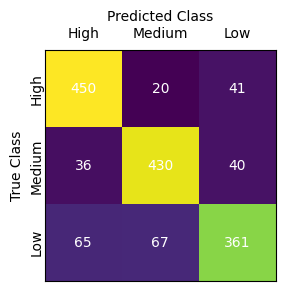

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3))
cm.plot(axs)
fig.savefig(f'../pictures/plots/cm_{MODEL}_{LABEL}.pdf')